The following example notebook implements standard diffusion
with a simple CNN model to generate realistic MNIST digits.

This is a modified implementation of `minDiffusion`
which implements [DDPM](https://arxiv.org/abs/2006.11239).

To run this example notebook,
install requirements as in `requirements.txt` (for example, `pip install -r requirements.txt`).
You may also wish to follow system-dependent PyTorch instructions
[here](https://pytorch.org/) to install accelerated
versions of PyTorch, but note they are not needed
(I am testing this on my laptop).

If you do use accelerated hardware, make sure that your code
is still compatible with CPU-only installs.

First, let's create a folder to store example images:

In [1]:
!mkdir -p contents
!pip install accelerate

In [2]:
from typing import Dict, Tuple

import numpy as np
import torch
import torch.nn as nn
from accelerate import Accelerator
from tqdm import tqdm
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image, make_grid

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


The following function creates a DDPM training schedule for use when evaluating
and training the diffusion model:

In [4]:
def ddpm_schedules(beta1: float, beta2: float, T: int) -> Dict[str, torch.Tensor]:
    """Returns pre-computed schedules for DDPM sampling with a linear noise schedule."""
    assert beta1 < beta2 < 1.0, "beta1 and beta2 must be in (0, 1)"

    beta_t = (beta2 - beta1) * torch.arange(0, T + 1, dtype=torch.float32) / T + beta1
    alpha_t = torch.exp(torch.cumsum(torch.log(1 - beta_t), dim=0))  # Cumprod in log-space (better precision)

    return {"beta_t": beta_t, "alpha_t": alpha_t}


Next, we create a simple 2D convolutional neural network. This network
is essentially going to try to estimate the diffusion process --- we
can then use this network to generate realistic images.

First, we create a single CNN block which we will stack to create the
full network. We use `LayerNorm` for stable training and no batch dependence.

In [5]:
class CNNBlock(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        *,
        expected_shape,
        act=nn.GELU,
        kernel_size=7,
    ):
        super().__init__()

        self.net = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, padding=kernel_size // 2),
                        nn.LayerNorm((out_channels, *expected_shape)),
            # must be modified to nn.LayerNorm((out_channels, *expected_shape)),

            act()
        )

    def forward(self, x):
        return self.net(x)

We then create the full CNN model, which is a stack of these blocks
according to the `n_hidden` tuple, which specifies the number of
channels at each hidden layer.

In [6]:
class CNN(nn.Module):
    def __init__(
        self,
        in_channels,
        expected_shape=(28, 28),
        n_hidden=(64, 128, 64),
        kernel_size=7,
        last_kernel_size=3,
        time_embeddings=16,
        act=nn.GELU,
    ) -> None:
        super().__init__()
        last = in_channels

        self.blocks = nn.ModuleList()
        for hidden in n_hidden:
            self.blocks.append(
                CNNBlock(
                    last,
                    hidden,
                    expected_shape=expected_shape,
                    kernel_size=kernel_size,
                    act=act,
                )
            )
            last = hidden

        # The final layer, we use a regular Conv2d to get the
        # correct scale and shape (and avoid applying the activation)
        self.blocks.append(
            nn.Conv2d(
                last,
                in_channels,
                last_kernel_size,
                padding=last_kernel_size // 2,
            )
        )

        ## This part is literally just to put the single scalar "t" into the CNN
        ## in a nice, high-dimensional way:
        self.time_embed = nn.Sequential(
            nn.Linear(time_embeddings * 2, 128), act(),
            nn.Linear(128, 128), act(),
            nn.Linear(128, 128), act(),
            nn.Linear(128, n_hidden[0]),
        )
        frequencies = torch.tensor(
            [0] + [2 * np.pi * 1.5**i for i in range(time_embeddings - 1)]
        )
        self.register_buffer("frequencies", frequencies)

    def time_encoding(self, t: torch.Tensor) -> torch.Tensor:
        phases = torch.concat(
            (
                torch.sin(t[:, None] * self.frequencies[None, :]),
                torch.cos(t[:, None] * self.frequencies[None, :]) - 1,
            ),
            dim=1,
        )

        return self.time_embed(phases)[:, :, None, None]

    def forward(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        # Shapes of input:
        #    x: (batch, chan, height, width)
        #    t: (batch,)

        embed = self.blocks[0](x)
        # ^ (batch, n_hidden[0], height, width)

        # Add information about time along the diffusion process
        #  (Providing this information by superimposing in latent space)
        embed += self.time_encoding(t)
        #         ^ (batch, n_hidden[0], 1, 1) - thus, broadcasting
        #           to the entire spatial domain

        for block in self.blocks[1:]:
            embed = block(embed)

        return embed

In [7]:
!pip install kornia

  Obtaining dependency information for kornia from https://files.pythonhosted.org/packages/ac/fa/5612c4b1ad83b3044062e9dd0ca3c91937d8023cff0836269e18573655b0/kornia-0.7.2-py2.py3-none-any.whl.metadata
  Using cached kornia-0.7.2-py2.py3-none-any.whl.metadata (12 kB)
  Obtaining dependency information for kornia-rs>=0.1.0 from https://files.pythonhosted.org/packages/01/0a/efbf59b0a6140153e05ff2576b2980637cf7b3d7a3587623e766c835c700/kornia_rs-0.1.2-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Using cached kornia_rs-0.1.2-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.3 kB)
Using cached kornia-0.7.2-py2.py3-none-any.whl (825 kB)
Using cached kornia_rs-0.1.2-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (2.4 MB)


In [8]:
import torch
import torch.nn.functional as F
from torchvision.transforms import functional as TF
from scipy.ndimage import gaussian_filter  # Import the gaussian_filter function


def adjust_contrast(self, x: torch.Tensor, intensity: float) -> torch.Tensor:
      """
      Adjust the contrast of the images.
      The range of contrast adjustment increases with the diffusion step intensity.
      """
      intensity = intensity.mean().cpu() 
      # Define the minimum and maximum contrast levels based on intensity
      min_contrast = 0.5 - intensity * 0.5  # Minimum contrast decreases with intensity
      max_contrast = 1.5 + intensity * 0.5  # Maximum contrast increases with intensity

      # Randomly choose a contrast level within the range for each image
      contrast_levels = torch.empty((x.size(0), 1, 1, 1), device=x.device).uniform_(min_contrast, max_contrast)

      # Adjust contrast
      means = x.mean(dim=[2, 3], keepdim=True)
      x = (x - means) * contrast_levels + means

      return x


def apply_cutout_masks(self, x: torch.Tensor, intensity: float) -> torch.Tensor:
      """
      Apply random cutout masks to simulate occlusions.
      The number and size of masks increase with the diffusion step intensity.
      """
      B, C, H, W = x.shape
      intensity = intensity.mean()

      num_masks = int(1 + intensity * 5)  # Starts with 1 mask, increases with intensity
      mask_size = int(3 + intensity * H / 4)  # Mask size starts from 3x3 and increases

      for _ in range(num_masks):
          # Randomly choose the center of the mask
          mask_center_x = torch.randint(0, W, (1,)).item()
          mask_center_y = torch.randint(0, H, (1,)).item()

          # Calculate the indices of the mask
          left = max(mask_center_x - mask_size // 2, 0)
          right = min(mask_center_x + mask_size // 2 + 1, W)
          top = max(mask_center_y - mask_size // 2, 0)
          bottom = min(mask_center_y + mask_size // 2 + 1, H)

          # Apply the mask
          x[:, :, top:bottom, left:right] = 0  # Assuming the background is black. Adjust if necessary.

      return x




def apply_3d_glasses_effect(x, intensity=5):
    """
    Applies a 3D glasses-inspired degradation effect to an image by simulating chromatic aberration.
    
    Parameters:
    - x: Input image tensor of shape (B, C, H, W), expected to be RGB.
    - intensity: Controls the amount of color shift. Higher values increase the effect.
    
    Returns:
    - Tensor with the 3D glasses effect applied.
    """
    # Resize and convert 1-channel images to 3-channel images
    processed_images = []
    for img in x:
        # Resize image to 299x299
        resized_img = TF.resize(img, size=(299, 299))
        # Convert grayscale to RGB by repeating the grayscale channel 3 times
        rgb_img = resized_img.repeat(1, 3, 1, 1)
        processed_images.append(rgb_img)

    # Stack all processed images into a single tensor
    preprocessed_images = torch.cat(processed_images, dim=0)
    B, C, H, W = preprocessed_images.shape
    if C < 3:
        raise ValueError("Input image must have at least 3 color channels for the 3D glasses effect.")
    
    # Creating shifted versions of the red and cyan (green+blue) channels
    # Intensity determines how much the channels are shifted
    shift = intensity // 2
  
    # Red channel is shifted left, and the cyan channels are shifted right
    red_shifted = torch.roll(preprocessed_images[:, 0:1, :, :], shifts=-shift.item(), dims=3)
    cyan_shifted = torch.roll(preprocessed_images[:, 1:, :, :], shifts=shift.item(), dims=3)
    
    # Reconstructing the image
    # Red channel gets the shifted red, green and blue get the averaged shifted cyan
    degraded = torch.cat([red_shifted, cyan_shifted.mean(dim=1, keepdim=True).expand(-1, 2, -1, -1)], dim=1)
    
    # Clamping the output to ensure valid pixel values
    degraded = torch.clamp(degraded, 0, 1)
    
    return degraded



Next, we define the actual diffusion model, which specifies the training
schedule, takes an arbitrary model for estimating the
diffusion process (such as the CNN above),
and computes the corresponding loss (as well as generating samples).

In [9]:
import torch
import torch.nn as nn
from typing import Tuple
import kornia




class DDPM(nn.Module):
    def __init__(
        self,
        gt,
        betas: Tuple[float, float],
        n_T: int,
        criterion: nn.Module = nn.MSELoss(),
    ) -> None:
        super().__init__()

        self.gt = gt

        noise_schedule = ddpm_schedules(betas[0], betas[1], n_T)

        self.register_buffer("beta_t", noise_schedule["beta_t"])
        self.register_buffer("alpha_t", noise_schedule["alpha_t"])

        self.n_T = n_T
        self.criterion = criterion


    def apply_custom_degradation(self, x: torch.Tensor, step: int) -> torch.Tensor:
        """
        Apply custom degradation based on Structural Perturbation and Contrast Variation.
        The degradation intensity scales with the diffusion step.
        """
        intensity = step / self.n_T
        # x = elastic_deformation(self, x, intensity)
        # print("shape after elastic: ", x)
        x = apply_cutout_masks(self, x, intensity)
        # # print("shape after masks: ", x)
        x = adjust_contrast(self, x, intensity)
        # print("shape after contrast: ", x)
        # x = apply_local_contrast_normalization(self, x, intensity)
        # print("shape after local contrast: ", x)
        # apply_3d_glasses_effect(x, intensity)
        return x

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        t = torch.randint(1, self.n_T, (x.shape[0],), device=x.device)
        eps = torch.randn_like(x)  # eps ~ N(0, 1)
        alpha_t = self.alpha_t[t, None, None, None]  # Get right shape for broadcasting

        # Apply custom degradation
        z_t = self.apply_custom_degradation(x, alpha_t)  # Pass `t` instead of `alpha_t` ?

        # Option to add original diffusion noise
        include_original_diffusion_noise = True  # Set to False if custom degradation replaces the need for this
        if include_original_diffusion_noise:
            z_t = torch.sqrt(alpha_t) * z_t + torch.sqrt(1 - alpha_t) * eps

        return self.criterion(eps, self.gt(z_t, t / self.n_T))

    def sample(self, n_sample: int, size, device) -> torch.Tensor:
        """Algorithm 18.2 in Prince"""

        _one = torch.ones(n_sample, device=device)
        z_t = torch.randn(n_sample, *size, device=device)
        for i in range(self.n_T, 0, -1):
            alpha_t = self.alpha_t[i]
            beta_t = self.beta_t[i]

            # First line of loop:
            z_t -= (beta_t / torch.sqrt(1 - alpha_t)) * self.gt(z_t, (i/self.n_T) * _one)
            z_t /= torch.sqrt(1 - beta_t)

            if i > 1:
                # Last line of loop:
                z_t += torch.sqrt(beta_t) * torch.randn_like(z_t)
            # (We don't add noise at the final step - i.e., the last line of the algorithm)

        return z_t
#     def sample(self, n_sample: int, size, device) -> torch.Tensor:
#         _one = torch.ones(n_sample, device=device)
#         z_t = torch.randn(n_sample, *size, device=device)
#         # Apply reverse custom degradation based on the step
#         z_t = self.apply_custom_degradation(z_t, 5)
#         for i in range(self.n_T, 0, -1):
#             alpha_t = self.alpha_t[i]
#             beta_t = self.beta_t[i]
#             z_t -= (beta_t / torch.sqrt(1 - alpha_t)) * self.gt(z_t, (i/self.n_T) * _one)
#             z_t /= torch.sqrt(1 - beta_t)

#             if i > 1:
#                 z_t += torch.sqrt(beta_t) * torch.randn_like(z_t)

#         return z_t


We will run this on MNIST. We perform some basic preprocessing, and set up the data loader:

In [10]:
tf = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0))])
# dataset = MNIST("./data", train=True, download=True, transform=tf)
dataset = MNIST("./data", train=True, download=False, transform=tf)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True, num_workers=4, drop_last=True)

We create our model with a given choice of hidden layers and activation function. We also choose a learning rate.

In [11]:
gt = CNN(in_channels=1, expected_shape=(28, 28), n_hidden=(16, 32, 32, 16), act=nn.GELU)
# For testing: (16, 32, 32, 16)
# For more capacity (for example): (64, 128, 256, 128, 64)
ddpm = DDPM(gt=gt, betas=(1e-4, 0.02), n_T=1000)
optim = torch.optim.Adam(ddpm.parameters(), lr=2e-4)

We could set up a GPU if we have one, which is done below.

Here, we use HuggingFace's `accelerate` library, which abstracts away all the `.to(device)` calls for us.
This lets us focus on the model itself rather than data movement.
It also does a few other tricks to speed up calculations.

PyTorch Lightning, which we discussed during the course, is another option that also handles a lot more, but is a bit heavyweight.
`accelerate` is a simpler option closer to raw PyTorch.
However, if you prefer, you could choose to use Lightning for the coursework!

In [12]:
accelerator = Accelerator()

# We wrap our model, optimizer, and dataloaders with `accelerator.prepare`,
# which lets HuggingFace's Accelerate handle the device placement and gradient accumulation.
ddpm, optim, dataloader = accelerator.prepare(ddpm, optim, dataloader)

Detected kernel version 4.14.336, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


First, let's just make sure this works:

In [13]:
for x, _ in dataloader:
    break

with torch.no_grad():
    ddpm(x)

Now, let's train it. You can exit early by interrupting the kernel. Images
are saved to the `contents` folder.

In [14]:
n_epoch = 100
losses = []

for i in range(n_epoch):
    ddpm.train()

    pbar = tqdm(dataloader)  # Wrap our loop with a visual progress bar
    for x, _ in pbar:
        optim.zero_grad()

        loss = ddpm(x)

        # loss.backward()
        accelerator.backward(loss)
        # ^Technically should be `accelerator.backward(loss)` but not necessary for local training

        losses.append(loss.item())
        avg_loss = np.average(losses[min(len(losses)-100, 0):])
        pbar.set_description(f"loss: {avg_loss:.3g}")  # Show running average of loss in progress bar

        optim.step()

    ddpm.eval()
    with torch.no_grad():
        xh = ddpm.sample(16, (1, 28, 28), accelerator.device)  # Can get device explicitly with `accelerator.device`
        grid = make_grid(xh, nrow=4)

        # Save samples to `./contents` directory
        save_image(grid, f"./contents/ddpm_sample_{i:04d}.png")

        # save model
        torch.save(ddpm.state_dict(), f"./ddpm_mnist.pth")
        torch.save(losses, "./ddpm_losses.pt")




loss: 0.0239: 100%|██████████| 468/468 [00:13<00:00, 33.44it/s]


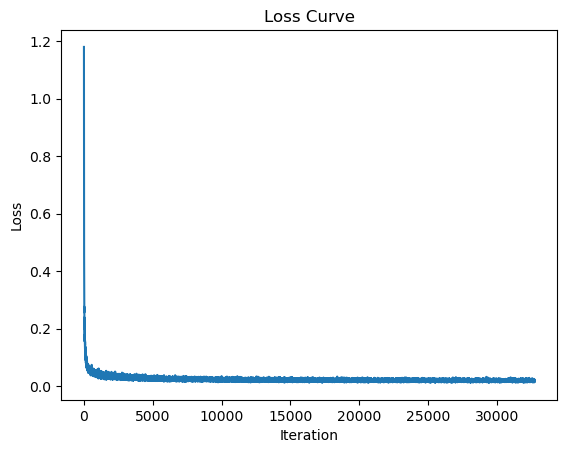

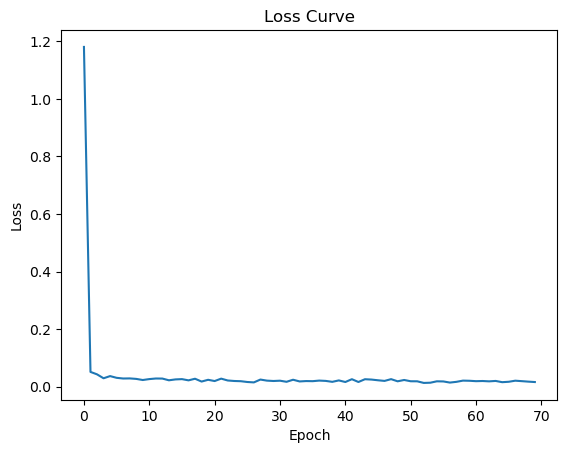

In [38]:
import matplotlib.pyplot as plt
ddpm.load_state_dict(torch.load('custom_mnist.pth', map_location=torch.device(device)))
losses = torch.load('custom_losses.pt', map_location=torch.device(device))
epoch_losses = []
for i in range(0, len(losses), 468):
    # print(losses[i])
    epoch_losses.append(losses[i])


plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.show()

plt.plot(epoch_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.show()

In [39]:
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
import torch
from torchvision.models import inception_v3
from torchvision.transforms import ToTensor

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
ddpm.to(device)
ddpm.eval() #put it in eval mode
ddpm.load_state_dict(torch.load('custom_mnist.pth', map_location=torch.device(device)))
with torch.no_grad(): # Making sure, since it is not needed
        generated_dataset= ddpm.sample(128, (1, 28, 28), device)
        # Should be a large number of samples to calculte the inception score





In [40]:
print(generated_dataset.shape)

torch.Size([128, 1, 28, 28])


In [41]:
import torch
import torch.nn.functional as F
from torchvision.models import inception_v3
from torchvision.transforms import functional as TF

def calculate_inception_score(generated_images):
    # Initialize the Inception model
    inception_model = inception_v3(pretrained=True)
    inception_model.eval()

    # Resize and convert 1-channel images to 3-channel images
    processed_images = []
    for img in generated_images:
        # Resize image to 299x299
        resized_img = TF.resize(img, size=(299, 299))
        # Convert grayscale to RGB by repeating the grayscale channel 3 times
        rgb_img = resized_img.repeat(1, 3, 1, 1)
        processed_images.append(rgb_img)

    # Stack all processed images into a single tensor
    preprocessed_images = torch.cat(processed_images, dim=0)

    # Pass the preprocessed images through the Inception model
    with torch.no_grad():
        logits = inception_model(preprocessed_images)

    # Calculate softmax probabilities
    probabilities = F.softmax(logits, dim=1)
    # Calculate the marginal distribution by averaging probabilities across all images
    marginal = torch.mean(probabilities, dim=0)
    # Calculate KL divergence for each image and then average
    kl_div = probabilities * (torch.log(probabilities) - torch.log(marginal.unsqueeze(0)))
    kl_div = kl_div.sum(dim=1)
    mean_kl_div = torch.mean(kl_div)

    # Compute the Inception Score
    inception_score = torch.exp(mean_kl_div).item()

    return inception_score
inception_score = calculate_inception_score(generated_dataset.cpu())
print("Inception Score:", inception_score)

Inception Score: 1.7262160778045654


In [42]:
print("MNIST dataset: ", dataset)
print("MNIST dataloader: ", dataloader)

MNIST dataset:  Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=1.0)
           )
MNIST dataloader:  <accelerate.data_loader.DataLoaderShard object at 0x7f2d73e036d0>


In [43]:
import torch
import numpy as np
from torchvision.models import inception_v3
from torchvision.transforms import functional as TF
from scipy.linalg import sqrtm

def calculate_fid(real_images, gen_images):
    # Load the pretrained Inception v3 model
    inception_model = inception_v3(pretrained=True)
    inception_model.eval()
    # Modify the model to return features from an intermediate layer
    inception_model.fc = torch.nn.Identity()

    def preprocess_and_extract_features(images):
        processed_images = []
        for img in images:
            # Resize and convert 1-channel images to 3-channel images
            resized_img = TF.resize(img, size=(299, 299))
            rgb_img = resized_img.repeat(1, 3, 1, 1)
            processed_images.append(rgb_img)

        # Stack all processed images into a single tensor
        preprocessed_images = torch.cat(processed_images, dim=0)

        # Extract features
        with torch.no_grad():
            features = inception_model(preprocessed_images)
        return features.cpu().numpy()

    # Preprocess and extract features for real and generated images
    real_features = preprocess_and_extract_features(real_images)
    gen_features = preprocess_and_extract_features(gen_images)

    # Calculate mean and covariance of features
    mu_real, sigma_real = np.mean(real_features, axis=0), np.cov(real_features, rowvar=False)
    mu_gen, sigma_gen = np.mean(gen_features, axis=0), np.cov(gen_features, rowvar=False)

    # Calculate the FID score
    ssdiff = np.sum((mu_real - mu_gen) ** 2.0)
    covmean = sqrtm(sigma_real.dot(sigma_gen))

    # Check for imaginary numbers in covmean and eliminate them
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = ssdiff + np.trace(sigma_real + sigma_gen - 2.0 * covmean)

    return fid
images, _ = next(iter(dataloader))
fid_score = calculate_fid(images.cpu(),generated_dataset.cpu())
print("FID Score:", fid_score)


FID Score: 68.43941096896712


In [44]:
# 'dataloader' is the DataLoader for MNIST
real_mnist, _ = next(iter(dataloader))

# If necessary, move to the same device as your generated images
real_mnist = real_mnist.to(device)

processed_mnist = []
for mnist in real_mnist:
    # Resize image to 299x299
    resized_mnist = TF.resize(mnist, size=(299, 299))
    # Convert grayscale to RGB by repeating the grayscale channel 3 times
    rgb_mnist = resized_mnist.repeat(1, 3, 1, 1)
    processed_mnist.append(rgb_mnist)
# Stack all processed images into a single tensor
real_images = torch.cat(processed_mnist, dim=0)
processed_imgs = []
for img in generated_dataset:
    resized_img = TF.resize(img, size=(299, 299))
    # Convert grayscale to RGB by repeating the grayscale channel 3 times
    rgb_img = resized_img.repeat(1, 3, 1, 1)
    processed_imgs.append(rgb_img)
# Stack all processed images into a single tensor
imgs = torch.cat(processed_imgs, dim=0)

real_images, generated_images = real_images.cpu(), imgs.cpu()



In [45]:
!pip install torchmetrics
!pip install torchmetrics[image]
!pip install torch-fidelity

In [46]:
from torchmetrics.image.fid import FrechetInceptionDistance
fid = FrechetInceptionDistance(feature= 2048)
# generate two slightly overlapping image intensity distributions

fid.update(real_images.cpu().to(dtype=torch.uint8), real=True)
fid.update(generated_images.to(dtype=torch.uint8), real=False)
fid.compute()

tensor(-2.4785e-12)

In [47]:
# print(gt)

In [48]:
# Calculate the negative log likelihood
losses = torch.Tensor(losses)
nll = torch.mean(torch.log(torch.sqrt(2 * torch.tensor(np.pi))) + 0.5 * torch.log(losses))

print("Negative Log Likelihood:", nll.item())
# Calculate the negative log likelihood bits per dim

bits_per_dim = nll.item() / (torch.log(torch.tensor(2)).item())

print("Negative Log Likelihood (bits/dim):", bits_per_dim)

Negative Log Likelihood: -0.9925548434257507
Negative Log Likelihood (bits/dim): -1.4319539464858786


In [49]:
from torchmetrics.image.inception import InceptionScore
inception = InceptionScore()
inception.update(generated_images.to(dtype=torch.uint8))
inception.compute()

(tensor(1.), tensor(0.))

In [50]:
generated_images.shape

torch.Size([128, 3, 299, 299])

In [51]:
from torchmetrics.image.inception import InceptionScore
inception = InceptionScore()
inception.update(real_images.to(dtype=torch.uint8))
inception.compute()

(tensor(1.), tensor(0.))

In [52]:
# Compute FID using bansal et al. functions
# Inception and FID score calulated using functions from Bansal et al. 2022
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

try:
    from torchvision.models.utils import load_state_dict_from_url
except ImportError:
    from torch.utils.model_zoo import load_url as load_state_dict_from_url

# Inception weights ported to Pytorch from
# http://download.tensorflow.org/models/image/imagenet/inception-2015-12-05.tgz
FID_WEIGHTS_URL = 'https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth'  # noqa: E501


class InceptionV3(nn.Module):
    """Pretrained InceptionV3 network returning feature maps"""

    # Index of default block of inception to return,
    # corresponds to output of final average pooling
    DEFAULT_BLOCK_INDEX = 3

    # Maps feature dimensionality to their output blocks indices
    BLOCK_INDEX_BY_DIM = {
        64: 0,   # First max pooling features
        192: 1,  # Second max pooling featurs
        768: 2,  # Pre-aux classifier features
        2048: 3  # Final average pooling features
    }

    def __init__(self,
                 output_blocks=(DEFAULT_BLOCK_INDEX,),
                 resize_input=True,
                 normalize_input=True,
                 requires_grad=False,
                 use_fid_inception=True):
        """Build pretrained InceptionV3

        Parameters
        ----------
        output_blocks : list of int
            Indices of blocks to return features of. Possible values are:
                - 0: corresponds to output of first max pooling
                - 1: corresponds to output of second max pooling
                - 2: corresponds to output which is fed to aux classifier
                - 3: corresponds to output of final average pooling
        resize_input : bool
            If true, bilinearly resizes input to width and height 299 before
            feeding input to model. As the network without fully connected
            layers is fully convolutional, it should be able to handle inputs
            of arbitrary size, so resizing might not be strictly needed
        normalize_input : bool
            If true, scales the input from range (0, 1) to the range the
            pretrained Inception network expects, namely (-1, 1)
        requires_grad : bool
            If true, parameters of the model require gradients. Possibly useful
            for finetuning the network
        use_fid_inception : bool
            If true, uses the pretrained Inception model used in Tensorflow's
            FID implementation. If false, uses the pretrained Inception model
            available in torchvision. The FID Inception model has different
            weights and a slightly different structure from torchvision's
            Inception model. If you want to compute FID scores, you are
            strongly advised to set this parameter to true to get comparable
            results.
        """
        super(InceptionV3, self).__init__()

        self.resize_input = resize_input
        self.normalize_input = normalize_input
        self.output_blocks = sorted(output_blocks)
        self.last_needed_block = max(output_blocks)

        assert self.last_needed_block <= 3, \
            'Last possible output block index is 3'

        self.blocks = nn.ModuleList()

        if use_fid_inception:
            inception = fid_inception_v3()
        else:
            inception = _inception_v3(pretrained=True)

        # Block 0: input to maxpool1
        block0 = [
            inception.Conv2d_1a_3x3,
            inception.Conv2d_2a_3x3,
            inception.Conv2d_2b_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2)
        ]
        self.blocks.append(nn.Sequential(*block0))

        # Block 1: maxpool1 to maxpool2
        if self.last_needed_block >= 1:
            block1 = [
                inception.Conv2d_3b_1x1,
                inception.Conv2d_4a_3x3,
                nn.MaxPool2d(kernel_size=3, stride=2)
            ]
            self.blocks.append(nn.Sequential(*block1))

        # Block 2: maxpool2 to aux classifier
        if self.last_needed_block >= 2:
            block2 = [
                inception.Mixed_5b,
                inception.Mixed_5c,
                inception.Mixed_5d,
                inception.Mixed_6a,
                inception.Mixed_6b,
                inception.Mixed_6c,
                inception.Mixed_6d,
                inception.Mixed_6e,
            ]
            self.blocks.append(nn.Sequential(*block2))

        # Block 3: aux classifier to final avgpool
        if self.last_needed_block >= 3:
            block3 = [
                inception.Mixed_7a,
                inception.Mixed_7b,
                inception.Mixed_7c,
                nn.AdaptiveAvgPool2d(output_size=(1, 1))
            ]
            self.blocks.append(nn.Sequential(*block3))

        for param in self.parameters():
            param.requires_grad = requires_grad

    def forward(self, inp):
        """Get Inception feature maps

        Parameters
        ----------
        inp : torch.autograd.Variable
            Input tensor of shape Bx3xHxW. Values are expected to be in
            range (0, 1)

        Returns
        -------
        List of torch.autograd.Variable, corresponding to the selected output
        block, sorted ascending by index
        """
        outp = []
        x = inp

        if self.resize_input:
            x = F.interpolate(x,
                              size=(299, 299),
                              mode='bilinear',
                              align_corners=False)

        if self.normalize_input:
            x = 2 * x - 1  # Scale from range (0, 1) to range (-1, 1)

        for idx, block in enumerate(self.blocks):
            x = block(x)
            if idx in self.output_blocks:
                outp.append(x)

            if idx == self.last_needed_block:
                break

        return outp


def _inception_v3(*args, **kwargs):
    """Wraps `torchvision.models.inception_v3`

    Skips default weight inititialization if supported by torchvision version.
    See https://github.com/mseitzer/pytorch-fid/issues/28.
    """
    try:
        version = tuple(map(int, torchvision.__version__.split('.')[:2]))
    except ValueError:
        # Just a caution against weird version strings
        version = (0,)

    if version >= (0, 6):
        kwargs['init_weights'] = False

    return torchvision.models.inception_v3(*args, **kwargs)


def fid_inception_v3():
    """Build pretrained Inception model for FID computation

    The Inception model for FID computation uses a different set of weights
    and has a slightly different structure than torchvision's Inception.

    This method first constructs torchvision's Inception and then patches the
    necessary parts that are different in the FID Inception model.
    """
    inception = _inception_v3(num_classes=1008,
                              aux_logits=False,
                              pretrained=False)
    inception.Mixed_5b = FIDInceptionA(192, pool_features=32)
    inception.Mixed_5c = FIDInceptionA(256, pool_features=64)
    inception.Mixed_5d = FIDInceptionA(288, pool_features=64)
    inception.Mixed_6b = FIDInceptionC(768, channels_7x7=128)
    inception.Mixed_6c = FIDInceptionC(768, channels_7x7=160)
    inception.Mixed_6d = FIDInceptionC(768, channels_7x7=160)
    inception.Mixed_6e = FIDInceptionC(768, channels_7x7=192)
    inception.Mixed_7b = FIDInceptionE_1(1280)
    inception.Mixed_7c = FIDInceptionE_2(2048)

    state_dict = load_state_dict_from_url(FID_WEIGHTS_URL, progress=True)
    inception.load_state_dict(state_dict)
    return inception


class FIDInceptionA(torchvision.models.inception.InceptionA):
    """InceptionA block patched for FID computation"""
    def __init__(self, in_channels, pool_features):
        super(FIDInceptionA, self).__init__(in_channels, pool_features)

    def forward(self, x):
        branch1x1 = self.branch1x1(x)

        branch5x5 = self.branch5x5_1(x)
        branch5x5 = self.branch5x5_2(branch5x5)

        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)
        branch3x3dbl = self.branch3x3dbl_3(branch3x3dbl)

        # Patch: Tensorflow's average pool does not use the padded zero's in
        # its average calculation
        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1,
                                   count_include_pad=False)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch5x5, branch3x3dbl, branch_pool]
        return torch.cat(outputs, 1)


class FIDInceptionC(torchvision.models.inception.InceptionC):
    """InceptionC block patched for FID computation"""
    def __init__(self, in_channels, channels_7x7):
        super(FIDInceptionC, self).__init__(in_channels, channels_7x7)

    def forward(self, x):
        branch1x1 = self.branch1x1(x)

        branch7x7 = self.branch7x7_1(x)
        branch7x7 = self.branch7x7_2(branch7x7)
        branch7x7 = self.branch7x7_3(branch7x7)

        branch7x7dbl = self.branch7x7dbl_1(x)
        branch7x7dbl = self.branch7x7dbl_2(branch7x7dbl)
        branch7x7dbl = self.branch7x7dbl_3(branch7x7dbl)
        branch7x7dbl = self.branch7x7dbl_4(branch7x7dbl)
        branch7x7dbl = self.branch7x7dbl_5(branch7x7dbl)

        # Patch: Tensorflow's average pool does not use the padded zero's in
        # its average calculation
        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1,
                                   count_include_pad=False)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch7x7, branch7x7dbl, branch_pool]
        return torch.cat(outputs, 1)


class FIDInceptionE_1(torchvision.models.inception.InceptionE):
    """First InceptionE block patched for FID computation"""
    def __init__(self, in_channels):
        super(FIDInceptionE_1, self).__init__(in_channels)

    def forward(self, x):
        branch1x1 = self.branch1x1(x)

        branch3x3 = self.branch3x3_1(x)
        branch3x3 = [
            self.branch3x3_2a(branch3x3),
            self.branch3x3_2b(branch3x3),
        ]
        branch3x3 = torch.cat(branch3x3, 1)

        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)
        branch3x3dbl = [
            self.branch3x3dbl_3a(branch3x3dbl),
            self.branch3x3dbl_3b(branch3x3dbl),
        ]
        branch3x3dbl = torch.cat(branch3x3dbl, 1)

        # Patch: Tensorflow's average pool does not use the padded zero's in
        # its average calculation
        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1,
                                   count_include_pad=False)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch3x3, branch3x3dbl, branch_pool]
        return torch.cat(outputs, 1)


class FIDInceptionE_2(torchvision.models.inception.InceptionE):
    """Second InceptionE block patched for FID computation"""
    def __init__(self, in_channels):
        super(FIDInceptionE_2, self).__init__(in_channels)

    def forward(self, x):
        branch1x1 = self.branch1x1(x)

        branch3x3 = self.branch3x3_1(x)
        branch3x3 = [
            self.branch3x3_2a(branch3x3),
            self.branch3x3_2b(branch3x3),
        ]
        branch3x3 = torch.cat(branch3x3, 1)

        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)
        branch3x3dbl = [
            self.branch3x3dbl_3a(branch3x3dbl),
            self.branch3x3dbl_3b(branch3x3dbl),
        ]
        branch3x3dbl = torch.cat(branch3x3dbl, 1)

        # Patch: The FID Inception model uses max pooling instead of average
        # pooling. This is likely an error in this specific Inception
        # implementation, as other Inception models use average pooling here
        # (which matches the description in the paper).
        branch_pool = F.max_pool2d(x, kernel_size=3, stride=1, padding=1)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch3x3, branch3x3dbl, branch_pool]
        return torch.cat(outputs, 1)

In [53]:

"""Calculates the Frechet Inception Distance (FID) to evalulate GANs

The FID metric calculates the distance between two distributions of images.
Typically, we have summary statistics (mean & covariance matrix) of one
of these distributions, while the 2nd distribution is given by a GAN.

When run as a stand-alone program, it compares the distribution of
images that are stored as PNG/JPEG at a specified location with a
distribution given by summary statistics (in pickle format).

The FID is calculated by assuming that X_1 and X_2 are the activations of
the pool_3 layer of the inception net for generated samples and real world
samples respectively.

See --help to see further details.

Code apapted from https://github.com/bioinf-jku/TTUR to use PyTorch instead
of Tensorflow

Copyright 2018 Institute of Bioinformatics, JKU Linz

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

   http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
"""
import os
import pathlib
from argparse import ArgumentDefaultsHelpFormatter, ArgumentParser

import numpy as np
import torch
from torchvision.transforms import functional as TF
from PIL import Image
from scipy import linalg
from torch.nn.functional import adaptive_avg_pool2d

try:
    from tqdm import tqdm
except ImportError:
    # If tqdm is not available, provide a mock version of it
    def tqdm(x):
        return x


# parser = ArgumentParser(formatter_class=ArgumentDefaultsHelpFormatter)
# parser.add_argument('--batch-size', type=int, default=50,
#                     help='Batch size to use')
# parser.add_argument('--num-workers', type=int,
#                     help=('Number of processes to use for data loading. '
#                           'Defaults to `min(8, num_cpus)`'))
# parser.add_argument('--device', type=str, default=None,
#                     help='Device to use. Like cuda, cuda:0 or cpu')
# parser.add_argument('--dims', type=int, default=2048,
#                     choices=list(InceptionV3.BLOCK_INDEX_BY_DIM),
#                     help=('Dimensionality of Inception features to use. '
#                           'By default, uses pool3 features'))
# parser.add_argument('path', type=str, nargs=2,
#                     help=('Paths to the generated images or '
#                           'to .npz statistic files'))
#
IMAGE_EXTENSIONS = {'bmp', 'jpg', 'jpeg', 'pgm', 'png', 'ppm',
                    'tif', 'tiff', 'webp'}


class ImagePathDataset(torch.utils.data.Dataset):
    def __init__(self, files, transforms=None):
        self.files = files
        self.transforms = transforms

    def __len__(self):
        return len(self.files)

    def __getitem__(self, i):
        path = self.files[i]
        img = Image.open(path).convert('RGB')
        if self.transforms is not None:
            img = self.transforms(img)
        return img




def get_activations(samples, model, batch_size=50, dims=2048, device='cpu',
                    num_workers=1):
    """Calculates the activations of the pool_3 layer for all images.

    Params:
    -- files       : List of image files paths
    -- model       : Instance of inception model
    -- batch_size  : Batch size of images for the model to process at once.
                     Make sure that the number of samples is a multiple of
                     the batch size, otherwise some samples are ignored. This
                     behavior is retained to match the original FID score
                     implementation.
    -- dims        : Dimensionality of features returned by Inception
    -- device      : Device to run calculations
    -- num_workers : Number of parallel dataloader workers

    Returns:
    -- A numpy array of dimension (num images, dims) that contains the
       activations of the given tensor when feeding inception with the
       query tensor.
    """
    model.eval()
    # samples is a torch array

    pred_arr = np.empty((samples.shape[0], dims))
    start_idx = 0

    n_iters = samples.shape[0] // batch_size # try to make this an int

    for i in range(n_iters):
        batch = samples[i*batch_size: i*batch_size + batch_size]
        batch = batch.to(device)

        with torch.no_grad():
            pred = model(batch)[0]

        # If model output is not scalar, apply global spatial average pooling.
        # This happens if you choose a dimensionality not equal 2048.
        if pred.size(2) != 1 or pred.size(3) != 1:
            pred = adaptive_avg_pool2d(pred, output_size=(1, 1))

        pred = pred.squeeze(3).squeeze(2).cpu().numpy()

        pred_arr[start_idx:start_idx + pred.shape[0]] = pred

        start_idx = start_idx + pred.shape[0]

    return pred_arr

def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    """Numpy implementation of the Frechet Distance.
    The Frechet distance between two multivariate Gaussians X_1 ~ N(mu_1, C_1)
    and X_2 ~ N(mu_2, C_2) is
            d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).

    Stable version by Dougal J. Sutherland.

    Params:
    -- mu1   : Numpy array containing the activations of a layer of the
               inception net (like returned by the function 'get_predictions')
               for generated samples.
    -- mu2   : The sample mean over activations, precalculated on an
               representative data set.
    -- sigma1: The covariance matrix over activations for generated samples.
    -- sigma2: The covariance matrix over activations, precalculated on an
               representative data set.

    Returns:
    --   : The Frechet Distance.
    """

    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, \
        'Training and test mean vectors have different lengths'
    assert sigma1.shape == sigma2.shape, \
        'Training and test covariances have different dimensions'

    diff = mu1 - mu2

    # Product might be almost singular
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = ('fid calculation produces singular product; '
               'adding %s to diagonal of cov estimates') % eps
        print(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    # Numerical error might give slight imaginary component
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return (diff.dot(diff) + np.trace(sigma1)
            + np.trace(sigma2) - 2 * tr_covmean)

def calculate_activation_statistics(samples, model, batch_size=50, dims=2048,
                                    device='cpu', num_workers=1):
    """Calculation of the statistics used by the FID.
    Params:
    -- files       : List of image files paths
    -- model       : Instance of inception model
    -- batch_size  : The images numpy array is split into batches with
                     batch size batch_size. A reasonable batch size
                     depends on the hardware.
    -- dims        : Dimensionality of features returned by Inception
    -- device      : Device to run calculations
    -- num_workers : Number of parallel dataloader workers

    Returns:
    -- mu    : The mean over samples of the activations of the pool_3 layer of
               the inception model.
    -- sigma : The covariance matrix of the activations of the pool_3 layer of
               the inception model.
    """
    act = get_activations(samples, model, batch_size, dims, device, num_workers)
    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)
    return mu, sigma


def compute_statistics_of_samples(samples, model, batch_size, dims, device,
                               num_workers=1):

    m, s = calculate_activation_statistics(samples, model, batch_size,
                                           dims, device, num_workers)

    return m, s

def calculate_fid_given_samples(samples, batch_size=50, device='cuda:0', dims=2048, num_workers=1):
    """Calculates the FID of two sample collection"""

    block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[dims]

    model = InceptionV3([block_idx]).to(device)

    m1, s1 = compute_statistics_of_samples(samples[0], model, batch_size,
                                        dims, device, num_workers)
    m2, s2 = compute_statistics_of_samples(samples[1], model, batch_size,
                                        dims, device, num_workers)
    fid_value = calculate_frechet_distance(m1, s1, m2, s2)

    return fid_value

In [54]:

fid = calculate_fid_given_samples([real_images, generated_images],device = device)
print("Fid score: ", fid)

Fid score:  78.30155370263714
